In [3]:
import pandas as pd
import random 
import json
import matplotlib.pyplot as plt

from functions import join_stocks_crypto, generate_rand_portfolios
from functions_post_clustering import reoptimize_weights, dunn_bonferroni

In [4]:
#GET THE DATA IN

#Main part data 2022-2023
df_all_stocks = pd.read_csv('stocks_data_filtered_volatility.csv',index_col='Date')
cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')
joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left')
joined_df.index = pd.to_datetime(joined_df.index)
returns_all = joined_df.pct_change()

#Out-of-sample data 2024:
df_stocks_24 = pd.read_csv('stocks_data_out_sample_2024_foltered_volatility.csv',index_col='Date')
cryptos_df_24 = pd.read_csv('cryptos_data_out_sample_2024.csv', index_col='timestamp')
joined_df_24 = join_stocks_crypto(cryptos_df_24, df_stocks_24, mode = 'stocks_left')
joined_df_24.index = pd.to_datetime(joined_df_24.index)
returns_all_24 = joined_df_24.pct_change().dropna()


tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)


#Reassemble the portfolio jsons for minvar
min_var_portfolios = dict()
for i in range(1,1000):
    with open(f'min_variance_portfolio_jsons/my_dict{i}.json') as f:
        port = json.load(f)
        min_var_portfolios.update(port)

# with open(f"full_optimized_min_variance.json", "w") as f:
#     json.dump(min_var_portfolios, f, indent=4)

rand_ports_standard = random_portfolios.copy()
rand_ports_maxsharpe = reoptimize_weights(joined_df, random_portfolios, how='max_sharpe', min_weight=0.01)
rand_ports_equal_weights = reoptimize_weights(joined_df, random_portfolios, how='equal_weights', min_weight=0.01)

minvar_port_standard = min_var_portfolios.copy()
minvar_ports_maxsharpe = reoptimize_weights(joined_df, min_var_portfolios, how='max_sharpe', min_weight=0.01)
minvar_ports_equal_weights = reoptimize_weights(joined_df, min_var_portfolios, how='equal_weights', min_weight=0.01)


with open('all_optimized_sets_for_simulation.json') as f:
    
    crypto_supplemented_sets = json.load(f)


portfolio_sets = {#'rand_ports_standard': rand_ports_standard,
                  'rand_ports_maxsharpe': rand_ports_maxsharpe, 
                  'rand_ports_equalw': rand_ports_equal_weights,
                  #'minvar_port_standard': minvar_port_standard,  
                  'minvar_ports_maxsharpe': minvar_ports_maxsharpe, 
                  'minvar_ports_equalw': minvar_ports_equal_weights}

all_sets = portfolio_sets | crypto_supplemented_sets

equalw_sets = {k: v for k, v in all_sets.items() if 'equalw' in k}
maxsharpe_sets = {k: v for k, v in all_sets.items() if 'equalw' not in k}

C:\Users\Kirill\AppData\Local\Temp\ipykernel_11672\2802784697.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns_all_24 = joined_df_24.pct_change().dropna()


SIMULATE AND EVALUATE

In [5]:
#FULL CLAUDE GENERATION CODE
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import mstats, normaltest
import matplotlib.pyplot as plt
from datetime import timedelta
import random

# Missing function: calculate_cumulative_returns
def calculate_cumulative_returns(returns):
    """
    Calculate cumulative returns from daily returns.
    
    Parameters:
    -----------
    returns : numpy.ndarray
        Array of daily returns
        
    Returns:
    --------
    numpy.ndarray
        Cumulative returns
    """
    return np.cumprod(1 + returns, axis=0) - 1

# Missing function: calculate_var_cvar
def calculate_var_cvar(returns, confidence_level=0.05, initial_value=100):
    """
    Calculate Value at Risk (VaR) and Conditional Value at Risk (CVaR)
    
    Parameters:
    -----------
    returns : numpy.ndarray
        Array of daily returns
    confidence_level : float
        Confidence level for VaR calculation (default: 0.05)
    initial_value : float
        Initial portfolio value (default: 100)
        
    Returns:
    --------
    tuple
        (VaR, CVaR)
    """
    VaR = abs(np.percentile(returns, confidence_level * 100)) * initial_value
    worst_losses = returns[returns <= -VaR/initial_value]
    CVaR = abs(worst_losses.mean()) * initial_value if len(worst_losses) > 0 else VaR
    
    return VaR, CVaR

def run_simulation(portfolio_dict, returns_for_portfolio, n_sims=100, t=100, 
                  distribution_model='multivar_norm', plot=False, initialPortfolio=100, 
                  winsorize=False, winsorize_limits=(0.01, 0.01), use_log_returns=False):
    """
    Run Monte Carlo simulation for portfolio returns.
    
    Parameters:
    -----------
    portfolio_dict : dict
        Dictionary with tickers as keys and weights as values
    returns_for_portfolio : pandas.DataFrame
        DataFrame with dates as index and tickers as columns containing returns
    n_sims : int
        Number of simulations to run
    t : int
        Number of time periods to simulate
    distribution_model : str
        Distribution model to use ('multivar_norm', 'multivar_t', 'bootstrap')
    plot : bool
        Whether to plot the simulation results
    initialPortfolio : float
        Initial portfolio value
    winsorize : bool
        Whether to winsorize returns
    winsorize_limits : tuple
        Limits for winsorization
    use_log_returns : bool
        Whether to use log returns (for consistency with out-of-sample analysis)
        
    Returns:
    --------
    numpy.ndarray
        Simulated portfolio paths
    """
    returns_for_portfolio = returns_for_portfolio[list(portfolio_dict.keys())]
    
    if winsorize:
        winsorized_returns = returns_for_portfolio.copy()
        
        for col in winsorized_returns.columns:
            winsorized_returns[col] = mstats.winsorize(winsorized_returns[col], limits=winsorize_limits)
        
        returns_for_portfolio = winsorized_returns

    # Convert to log returns if specified (for consistency with out-of-sample)
    if use_log_returns:
        invalid_mask = returns_for_portfolio <= -1.0
        if invalid_mask.any().any():
            log_compatible_returns = returns_for_portfolio.copy()
            log_compatible_returns[invalid_mask] = -0.99
            log_returns = np.log(1 + log_compatible_returns)
            returns_for_portfolio = log_returns
        else:
            returns_for_portfolio = np.log(1 + returns_for_portfolio)

    mean_returns = returns_for_portfolio.mean()
    cov_matrix = returns_for_portfolio.cov()

    weights = np.array([v for _, v in portfolio_dict.items()])

    meanM = np.tile(mean_returns, (t, 1))  # Shape: (T, n_assets)

    portfolio_sims = np.zeros((t, n_sims))

    L = np.linalg.cholesky(cov_matrix)  # Cholesky decomposition

    for sim in range(n_sims):
        if distribution_model == 'bootstrap':
            sampled_returns = returns_for_portfolio.bfill().sample(n=t, replace=True).values
            portfolio_returns = sampled_returns @ weights
        elif distribution_model in ['multivar_norm', 'multivar_t']:
            if distribution_model == 'multivar_norm':
                Z = np.random.normal(size=(t, len(portfolio_dict)))  # Shape: (T, n_assets)
                daily_returns = meanM + Z @ L.T  # Shape: (T, n_assets)
            elif distribution_model == 'multivar_t':
                df = 25  # degrees of freedom
                Z = np.random.normal(size=(t, len(portfolio_dict)))
                chi2 = np.random.chisquare(df, size=(t, 1))
                Z_t = Z / np.sqrt(chi2 / df)  # now Z_t has t-distributed marginals

                daily_returns = meanM + Z_t @ L.T

            portfolio_returns = daily_returns @ weights  # Shape: (T,)
        else:
            break
            
        # Convert back from log returns if necessary
        if use_log_returns:
            portfolio_returns = np.exp(portfolio_returns) - 1
        
        portfolio_sims[:, sim] = np.cumprod(1 + portfolio_returns) * initialPortfolio

    if plot:
        plt.figure(figsize=(10, 6))
        plt.plot(portfolio_sims)
        plt.title("Monte Carlo Simulated Portfolio Paths")
        plt.xlabel("Days")
        plt.ylabel("Portfolio Value")
        plt.show()

    return portfolio_sims

def out_of_sample_analysis(portfolio, return_data, start_date, period=126, 
                          calculate_metrics=True, plot_results=False, risk_free_rate=0.02, 
                          use_log_returns=False):
    """
    Perform traditional out-of-sample analysis for a portfolio over a specified forward period.
    
    Parameters:
    -----------
    portfolio : dict
        Dictionary with tickers as keys and weights as values
    price_data : pandas.DataFrame
        DataFrame with dates as index and tickers as columns containing returns
    start_date : str or datetime
        Date marking the beginning of out-of-sample period
    period : int
        Number of days for the forward period to analyze (default 126 ~= 6 months of trading days)
    calculate_metrics : bool
        Whether to calculate and return performance metrics
    plot_results : bool
        Whether to generate and return performance plots
    risk_free_rate : float
        Annual risk-free rate used for Sharpe ratio calculation
    use_log_returns : bool
        Whether to use log returns (for consistency with simulation)
    
    Returns:
    --------
    results : dict
        Dictionary containing performance metrics and return series for the period
    """
    if isinstance(start_date, str):
        start_date = pd.to_datetime(start_date)
    
    results = {}
    tickers = list(portfolio.keys())
    weights = np.array([portfolio[ticker] for ticker in tickers])
    
    missing_tickers = [ticker for ticker in tickers if ticker not in return_data.columns]
    if missing_tickers:
        raise ValueError(f"The following tickers are missing from price_data: {missing_tickers}")
    
    return_subset = return_data[tickers].copy()
    return_subset = return_subset.sort_index()
    oos_data = return_subset[return_subset.index >= start_date]
    
    if oos_data.empty:
        raise ValueError(f"No data available after start_date: {start_date}")
    
    period_data = oos_data.iloc[:period]
    
    # Calculate daily returns from prices
    returns = period_data.copy()

    if use_log_returns:
        invalid_mask = returns <= -1.0
        # if invalid_mask.any().any():
        #     log_compatible_returns = returns.copy()
        #     log_compatible_returns[invalid_mask] = -0.99
        #     log_returns = np.log(1 + log_compatible_returns)
        # else:
        #     log_returns = np.log(1 + returns)
            
        # portfolio_log_returns = log_returns.dot(weights)
        
        # # Convert back to simple returns for statistics
        # portfolio_returns = np.exp(portfolio_log_returns) - 1
        
        # # Calculate cumulative returns properly from log returns
        # cumulative_returns = np.exp(portfolio_log_returns.cumsum()) - 1
    else:
        # Simple returns method
        portfolio_returns = returns.dot(weights)
        cumulative_returns = (1 + portfolio_returns).cumprod() - 1

    results = {
        'returns': portfolio_returns,
        'cumulative_returns': cumulative_returns
    }
    
    if calculate_metrics:
        total_return = cumulative_returns.iloc[-1] if len(cumulative_returns) > 0 else 0
        trading_days = min(len(portfolio_returns), 252)
        
        # Annualization factor
        annual_factor = 252 / trading_days
        annualized_return = (1 + total_return) ** annual_factor - 1

        volatility = portfolio_returns.std() * np.sqrt(252)
        sharpe_ratio = (annualized_return - risk_free_rate) / volatility if volatility > 0 else 0
        
        # Non-annualized Sharpe ratio for the period
        rf_period = risk_free_rate * trading_days / 252  # Risk-free rate for the period
        volatility_period = portfolio_returns.std() * np.sqrt(trading_days)
        sharpe_period = (total_return - rf_period) / volatility_period if volatility_period > 0 else 0
        
        # Calculate VaR
        var_95 = abs(portfolio_returns.quantile(0.05)) * 100  # Scale to match the simulation's calculation
        
        results.update({
            'mean_period_return': total_return,
            'annualised_return': annualized_return,
            'sharpe_annualized': sharpe_ratio,
            'sharpe_period': sharpe_period,
            'var_95': var_95,
        })
    return results





def simulate_evaluate_portfolio_subset(portfolios_subset, return_df, n_sims=100, t=100, 
                                      distribution_model='multivar_norm', rf_annual=0.04, 
                                      seed=30, winsorize=False, winsorize_limits=(0.01, 0.01),
                                      use_log_returns=False):
    """
    Simulate and evaluate a subset of portfolios.
    
    Parameters:
    -----------
    portfolios_subset : dict
        Dictionary of dictionaries, where the outer keys are portfolio identifiers
        and the inner dictionaries are ticker->weight mappings
    return_df : pandas.DataFrame
        DataFrame with dates as index and tickers as columns containing RETURNS
    n_sims : int
        Number of simulations to run for each portfolio
    t : int
        Number of time periods to simulate
    distribution_model : str
        Distribution model to use ('multivar_norm', 'multivar_t', 'bootstrap', 'out_sample_direct')
    rf_annual : float
        Annual risk-free rate
    seed : int
        Random seed for reproducibility
    winsorize : bool
        Whether to winsorize returns
    winsorize_limits : tuple
        Limits for winsorization
    use_log_returns : bool
        Whether to use log returns for consistency between methods
        
    Returns:
    --------
    tuple
        (simulation_results, statistics, normality_test_results)
    """
    simulations_results_dict = dict()
    subset_statistics_df = pd.DataFrame()

    random.seed(seed)
    np.random.seed(seed)

    for i, portfolio_dict in portfolios_subset.items():
        # Making sure weights sum up to 1
        total = sum(portfolio_dict.values())
        portfolio_dict = {k: v / total for k, v in portfolio_dict.items()}

        if distribution_model == 'out_sample_direct':
        
            res = out_of_sample_analysis(
                portfolio_dict, 
                return_df, 
                '2024-01-01', 
                period=t, 
                calculate_metrics=True, 
                risk_free_rate=rf_annual, 
                plot_results=False, 
                use_log_returns=use_log_returns
            )
            
            mean_annual_return = res['annualised_return']
            mean_return = res['mean_period_return']
            sharpe_annual = res['sharpe_annualized']
            VaR_final = res['var_95']
            sharpe_period = res['sharpe_period']

            stat_results = pd.DataFrame({
                'annualised_return': [mean_annual_return],
                'mean_period_return': [mean_return],
                'sharpe_annualized': [sharpe_annual],
                'sharpe_period': [sharpe_period],
                'VaR': [VaR_final],
            })
            
            subset_statistics_df = pd.concat([subset_statistics_df, stat_results])
            
        else:
            # Run simulation with consistent parameters
            portfolio_sims = run_simulation(
                portfolio_dict, 
                return_df[list(portfolio_dict.keys())], 
                n_sims=n_sims, 
                t=t, 
                distribution_model=distribution_model, 
                plot=False, 
                winsorize=winsorize, 
                winsorize_limits=winsorize_limits,
                use_log_returns=use_log_returns
            )

            simulations_results_dict[i] = portfolio_sims

            # # Calculate daily returns from the simulated paths
            # daily_returns = (portfolio_sims[1:, :] - portfolio_sims[:-1, :]) / portfolio_sims[:-1, :]
            
            # # Final portfolio values
            # final_portfolio_values = portfolio_sims[-1, :]
            # initial_value = 100
            # holding_period_years = t / 252
            
            # # Calculate returns for the period
            # return_for_period = (final_portfolio_values - initial_value) / initial_value
            
            # # Calculate annualized returns
            # annualised_return = (final_portfolio_values / initial_value) ** (1 / holding_period_years) - 1
            
            # # Mean values
            # mean_return = np.mean(return_for_period)
            # mean_annual_return = np.mean(annualised_return)
            
            # # Volatility and Sharpe ratio calculations
            # # Daily statistics
            # mean_daily_return = np.mean(daily_returns)
            # std_daily_return = np.std(daily_returns)
            
            # # Annualized Sharpe ratio
            # rf_daily = rf_annual / 252
            # sharpe_daily = (mean_daily_return - rf_daily) / std_daily_return
            # sharpe_annual = sharpe_daily * np.sqrt(252)
            
            # # Sharpe ratio for the period
            # rf_period = rf_annual * t / 252
            # sharpe_period = (mean_return - rf_period) / np.std(return_for_period) if np.std(return_for_period) > 0 else 0
            



            # annualized_volatility = std_daily_return * np.sqrt(252)
            
            # # Annualized Sharpe ratio (consistent with out-of-sample)
            # sharpe_annual = (mean_annual_return - rf_annual) / annualized_volatility if annualized_volatility > 0 else 0
            
            # # Sharpe ratio for the period (consistent with out-of-sample)
            # rf_period = rf_annual * t / 252
            # #sharpe_period = (mean_return - rf_period) / np.std(return_for_period) * np.sqrt(t) if np.std(return_for_period) > 0 else 0








            # # VaR calculation
            # VaR_final, _ = calculate_var_cvar(daily_returns, confidence_level=0.05, initial_value=initial_value)

            
            daily_returns = (portfolio_sims[1:, :] - portfolio_sims[:-1, :]) / portfolio_sims[:-1, :]
            
            # For each simulation path, calculate key metrics
            all_stats = []
            
            for sim in range(n_sims):
                # Get the returns for this simulation
                sim_returns = daily_returns[:, sim]
                
                # Calculate cumulative return for the period
                final_value = portfolio_sims[-1, sim]
                initial_value = 100
                total_return = (final_value - initial_value) / initial_value
                
                # Calculate trading days (consistent with out-of-sample)
                trading_days = min(len(sim_returns), 252)
                
                # Annualization factor
                annual_factor = 252 / trading_days
                annualized_return = (1 + total_return) ** annual_factor - 1
                
                # Calculate volatility (annualized)
                volatility = sim_returns.std() * np.sqrt(252)
                
                # Calculate Sharpe ratio (annualized)
                sharpe_annual = (annualized_return - rf_annual) / volatility if volatility > 0 else 0
                
                # Calculate period Sharpe ratio
                rf_period = rf_annual * trading_days / 252
                volatility_period = sim_returns.std() * np.sqrt(trading_days)
                sharpe_period = (total_return - rf_period) / volatility_period if volatility_period > 0 else 0
                
                # Calculate VaR
                var_95 = abs(np.percentile(sim_returns, 5)) * 100
                
                all_stats.append({
                    'annualised_return': annualized_return,
                    'mean_period_return': total_return,
                    'sharpe_annualized': sharpe_annual,
                    'sharpe_period': sharpe_period,
                    'VaR': var_95
                })
            
            # Convert all simulations to a dataframe
            sim_stats_df = pd.DataFrame(all_stats)
            
            # Calculate averages across all simulations
            mean_annual_return = sim_stats_df['annualised_return'].mean()
            mean_return = sim_stats_df['mean_period_return'].mean()
            mean_sharpe_annual = sim_stats_df['sharpe_annualized'].mean()
            mean_sharpe_period = sim_stats_df['sharpe_period'].mean()
            mean_var = sim_stats_df['VaR'].mean()
            stat_results = pd.DataFrame({
                'annualised_return': [mean_annual_return],
                'mean_period_return': [mean_return],
                'sharpe_annualized': [mean_sharpe_annual],
                'sharpe_period': [mean_sharpe_period],
                'VaR': [mean_var],
            })

            subset_statistics_df = pd.concat([subset_statistics_df, stat_results])

    subset_statistics_df = subset_statistics_df.reset_index(drop=True)

    # Run normality test
    results_normality_test = {}
    for col in subset_statistics_df.columns:
        stat, p_value = normaltest(subset_statistics_df[col])
        results_normality_test[col] = {'statistic': stat, 'p_value': p_value}

    normality_results_df = pd.DataFrame(results_normality_test).T
    normality_results_df['normal'] = normality_results_df['p_value'] > 0.05

    return simulations_results_dict, subset_statistics_df, normality_results_df


In [6]:
import os

n_sims = 500
data_returns = returns_all
data_name = 'simulation'
distribution_models = ['bootstrap', 'multivar_t']  # example list of 3 models
time_periods = [126, 189, 252]
portfolio_sets_group = {'equalw': equalw_sets, 'maxsharpe': maxsharpe_sets}
windsorize = True
folder = 'simulation_results'


MODE = 'OUT_OF_SAMPLE_DIRECT' #'SIMULATION', "OUT_OF_SAMPLE_BOOTSTRAP"

if MODE == 'OUT_OF_SAMPLE_BOOTSTRAP':
    data_returns = returns_all_24
    data_name = 'simulation'
    distribution_models = ['bootstrap']
    windsorize = False
    folder = 'out_of_sample_bootstrap_results'

if MODE == 'OUT_OF_SAMPLE_DIRECT':
    data_returns = returns_all_24
    data_name = 'out_sample_direct'
    distribution_models = ['out_sample_direct']
    windsorize = False
    folder = 'out_of_sample_direct_results'

# Make sure output folders exist
os.makedirs(f'{folder}', exist_ok=True)

for set_name, set in portfolio_sets_group.items():
    for distribution_model in distribution_models:
        for time_period in time_periods:
            subset_statistics_results_dfs = dict()
            normality_results_dfs = dict()
            results_all_df = pd.DataFrame()

            for key, portfolio_set in set.items():
                simulations_results_dict, subset_statistics_df, normality = simulate_evaluate_portfolio_subset(
                    portfolio_set,
                    data_returns,
                    n_sims=n_sims,
                    t=time_period,
                    distribution_model=distribution_model,
                    winsorize=windsorize,
                    winsorize_limits=(0.01, 0.01)
                )

                # Initialize nested dicts
                subset_statistics_results_dfs.setdefault(time_period, {})
                normality_results_dfs.setdefault(time_period, {})

                subset_statistics_results_dfs[time_period][key] = subset_statistics_df
                normality_results_dfs[time_period][key] = normality

                # Mean series and concat
                mean_series = subset_statistics_df.mean()
                mean_df = pd.DataFrame(mean_series, columns=[(time_period, key)])
                mean_df.columns = pd.MultiIndex.from_tuples(mean_df.columns)
                results_all_df = pd.concat([results_all_df, mean_df], axis=1)

            # Save to CSV with clear naming
            csv_filename = f"{folder}/stats_{set_name}_{distribution_model}_t{time_period}.csv"
            results_all_df.to_csv(csv_filename)

            # Run and save Dunn-Bonferroni tests
            all_dunn_results = dict()
            dunn_bonferroni_test_results = dunn_bonferroni(subset_statistics_results_dfs[time_period], metrics='all')
            all_dunn_results[time_period] = dunn_bonferroni_test_results

            # Save to Excel
            excel_filename = f"{folder}/dunn_matrix_{set_name}_{distribution_model}_t{time_period}.xlsx"
            with pd.ExcelWriter(excel_filename) as writer:
                for sheet_name, df in all_dunn_results[time_period].items():
                    df.to_excel(writer, sheet_name=sheet_name[:31])


            print(f'Done for {set_name}_{distribution_model}_t{time_period}, moving on')

Done for equalw_out_sample_direct_t126, moving on
Done for equalw_out_sample_direct_t189, moving on
Done for equalw_out_sample_direct_t252, moving on
Done for maxsharpe_out_sample_direct_t126, moving on
Done for maxsharpe_out_sample_direct_t189, moving on
Done for maxsharpe_out_sample_direct_t252, moving on


In [ ]:
#Combine the results

# csv_folder = 'out_of_sample_direct_results/'
# output_excel = 'combined_stats_out_sample.xlsx'

# # Create Excel writer
# with pd.ExcelWriter(output_excel, engine='xlsxwriter') as writer:
#     for filename in os.listdir(csv_folder):
#         if filename.endswith('.csv'):
#             file_path = os.path.join(csv_folder, filename)
#             sheet_name = os.path.splitext(filename)[0][:31]  # Max 31 characters for Excel sheet names

#             # Read and write CSV to sheet
#             df = pd.read_csv(file_path)
#             df.to_excel(writer, sheet_name=sheet_name, index=False)


In [100]:
csv_folder = 'simulation_results/'
output_excel = 'combined_stats_out_sample.xlsx'

dfs = []
for filename in os.listdir(csv_folder):
    if filename.endswith('.csv'):
        file_path = os.path.join(csv_folder, filename)
        df = pd.read_csv(file_path)
        index_new = filename.replace('.csv', '')
        # Use filename (without extension) as the outer column index
        df.columns = pd.MultiIndex.from_product([[index_new], df.columns])

        dfs.append(df)

# Concatenate along the columns axis with multi-level columns
final_df = pd.concat(dfs, axis=1)

In [ ]:
final_df.T.to_csv('testing_results_format.csv')
final_df.T

A BIT OF ANALYSIS AND INVESTIGATION

In [8]:
import numpy as np

mean_returns_for_set = []
for key in simulations_results_dict.keys():
    x = pd.DataFrame(simulations_results_dict[key]).values[-1, :]
    initial_value = 100  # Your initial portfolio value
    holding_period_years = 162 / 252  # Convert days to year
    

    
    return_for_period = (x - initial_value) / initial_value
#     #annualised_return = (final_portfolio_values / initial_value) ** (1 / holding_period_years) - 1
#     annualised_return = (1 + return_for_period) ** (1/holding_period_years) - 1
#     mean_annualized_return = np.mean(annualised_return)
#     #print(np.mean(return_for_period))
#     avg_return_for_period = np.mean(return_for_period)#sum(return_for_period)/len(return_for_period)S
#     mean_returns_for_set.append(avg_return_for_period)


# sum(mean_returns_for_set) / len(mean_returns_for_set)

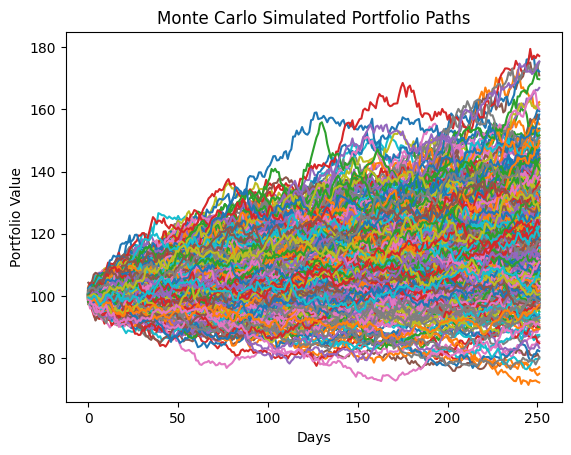

In [9]:
plt.plot(simulations_results_dict[key])
plt.title("Monte Carlo Simulated Portfolio Paths")
plt.xlabel("Days")
plt.ylabel("Portfolio Value")
plt.show()

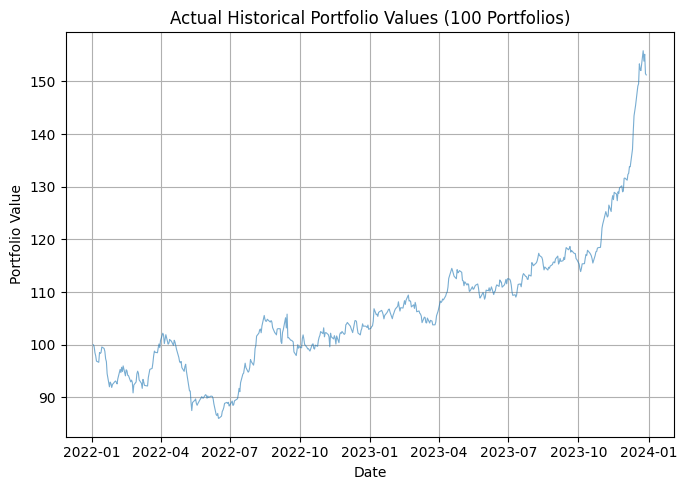

In [10]:
# portfolio = equalw_sets['minvar_w_cryptos_random_equalw']['portfolio_998']

# # Ensure weights sum to 1
# weights = pd.Series(portfolio)
# weights = weights / weights.sum()

# # Example: Load your historical prices into price_df (date index, tickers as columns)
# # price_df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

# # Normalize prices: start all at 100
# normalized_prices = joined_df[weights.index] / joined_df[weights.index].iloc[0] * 100

# # Multiply by weights to get portfolio value
# portfolio_value = normalized_prices.dot(weights)

# # Plot it
# plt.plot(portfolio_value)
# plt.title("Actual Historical Portfolio Value")
# plt.xlabel("Date")
# plt.ylabel("Portfolio Value")
# plt.grid(True)
# plt.show()



portfolios = equalw_sets['minvar_w_cryptos_random_equalw']

# Prepare the plot
plt.figure(figsize=(7, 5))

# Loop through each portfolio
for key, portfolio in portfolios.items():
    # if key == 'portfolio_25':
    #     continue
    # if key == 'portfolio_27':
    #     break
    if key == 'portfolio_26':
        pass
    else:
        continue
    
    weights = pd.Series(portfolio)
    weights = weights / weights.sum()  # Normalize weights

    # Align prices with portfolio tickers
    portfolio_prices = joined_df[weights.index]

    # Normalize prices
    normalized_prices = portfolio_prices / portfolio_prices.iloc[0] * 100

    # Compute portfolio value
    portfolio_value = normalized_prices.dot(weights)

    # Plot the result
    plt.plot(portfolio_value, alpha=0.6, linewidth=0.8)  # adjust alpha for better visibility

# Final plot settings
plt.title("Actual Historical Portfolio Values (100 Portfolios)")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
extreme_port = equalw_sets['minvar_w_cryptos_random_equalw']['portfolio_26'].copy()
stock = 'INJUSDT'
extreme_stock = {}
extreme_stock[stock] = extreme_port[stock]
extreme_port

{'PEP': 0.05555555555555555,
 'TLK': 0.05555555555555555,
 'RYTM': 0.05555555555555555,
 'AZN.L': 0.05555555555555555,
 'SHEL.L': 0.05555555555555555,
 'AD.AS': 0.05555555555555555,
 'KPN.AS': 0.05555555555555555,
 'REN.AS': 0.05555555555555555,
 '600900.SS': 0.05555555555555555,
 '601398.SS': 0.05555555555555555,
 '2914.T': 0.05555555555555555,
 '9432.T': 0.05555555555555555,
 '9434.T': 0.05555555555555555,
 '0941.HK': 0.05555555555555555,
 '6288.HK': 0.05555555555555555,
 'INJUSDT': 0.05555555555555555,
 'NEARUSDT': 0.05555555555555555,
 'UNIUSDT': 0.05555555555555555}

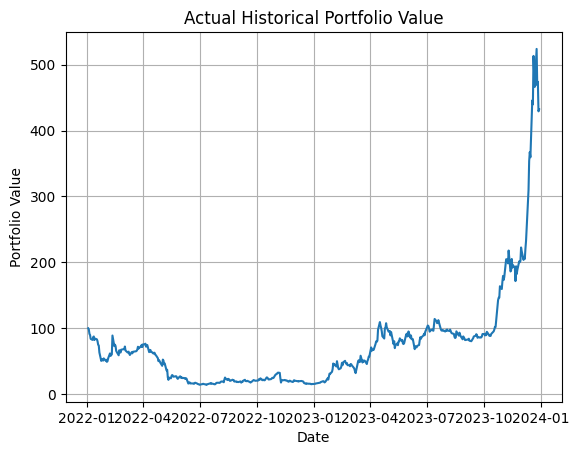

In [12]:
portfolio = extreme_stock.copy()
# Ensure weights sum to 1
weights = pd.Series(portfolio)
weights = weights / weights.sum()

# Example: Load your historical prices into price_df (date index, tickers as columns)
# price_df = pd.read_csv('your_file.csv', index_col='Date', parse_dates=True)

# Normalize prices: start all at 100
normalized_prices = joined_df[weights.index] / joined_df[weights.index].iloc[0] * 100

# Multiply by weights to get portfolio value
portfolio_value = normalized_prices.dot(weights)

# Plot it
plt.plot(portfolio_value)
plt.title("Actual Historical Portfolio Value")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.grid(True)
plt.show()

In [13]:
returns_all['INJUSDT'].sort_values()

Date
2022-06-13   -0.318737
2022-05-11   -0.308570
2022-11-09   -0.265091
2022-11-08   -0.258486
2022-05-09   -0.230292
                ...   
2023-12-11    0.245017
2023-10-23    0.303214
2023-03-13    0.364236
2022-02-11    0.473895
2022-01-03         NaN
Name: INJUSDT, Length: 520, dtype: float64